In [ ]:
import sys
import os
sys.path.append(os.path.abspath('..'))  # or the full path to the "project" directory
import numpy as np
import gpb

In [2]:
from gpbr.direct.common.boundary import Point3D
from gpbr.direct.common.distance import point_distance
def u3de(xp, t):
    point = Point3D(0,4, 0)
    dist =point_distance(point, xp)
    return 1/4/np.pi/t*np.exp(-dist**2/4/t)

In [3]:
from gpbr.direct.common.boundary import Point3D

def f1(x: Point3D , t: float) -> float:
    return u3de(x, t)

def f2(x: Point3D, t: float) -> float:
    return u3de(x, t)

In [4]:
from gpbr.direct.heat_equation.common import MFSConfig, Dimension

T = 1 # final time
N = 7 # N+1=10 time points
# m1 = 8
# m2 = 16
m1 = 8
m2 = 8
# m1 = 4
# m2 = 8
M = m1 * m2 # number of collocation points
ETA1 = 0.5
ETA2 = 2.0
config = MFSConfig(
    N=N,
    n_coll=M,
    n_source=M,
    T=T,
    eta1=ETA1,
    eta2=ETA2,
    f1=f1,
    f2=f2,
    dim = Dimension.THREE_D,
    n_coll_theta=m1,
    n_coll_phi=m2,
    n_source_theta=m1,
    n_source_phi=m2
)


In [5]:
from gpbr.direct.heat_equation.helpers import precalculate_mfs_data
mfs_data = precalculate_mfs_data(config)

In [6]:
# def r2(theta, phi):
#     return 2+np.sqrt(4.25+3*np.cos(3*theta))

# def dr2(theta, phi):
#     return ## TODO
# def r2(theta, phi):
#     return np.ones_like(theta)*1.0

# def dr2_theta(theta, phi):
#     return np.zeros_like(theta)

# def dr2_phi(theta, phi):
#     return np.zeros_like(theta)


# Define the radial function r(theta, phi)
def r2(theta, phi):
    return 1 + 0.5 * np.sin(2 * theta) * np.cos(phi)  # Example radial function

# Define the derivatives of r with respect to theta and phi
def dr2_dtheta(theta, phi):
    return 0.5 * 2 * np.cos(2 * theta) * np.cos(phi)

def dr2_dphi(theta, phi):
    return -0.5 * np.sin(2 * theta) * np.sin(phi)

In [7]:
from gpbr.direct.common.boundary import StarlikeSurface
Gamma2 = StarlikeSurface.from_radial_with_derivative(mfs_data.collocation, r2, dr2_dphi, dr2_dtheta)
Gamma2_source = StarlikeSurface.from_radial(mfs_data.source_collocation, lambda tetha,phi: ETA2*r2(tetha,phi))
Gamma2_rvals = r2(mfs_data.collocation.theta_grid, mfs_data.collocation.phi_grid)

In [8]:
%matplotlib widget
import matplotlib.pyplot as plt
def plot_poitns(Gamma: StarlikeSurface):
    fig_plot, ax_plot = plt.subplots(subplot_kw={"projection": "3d"})

    for p in Gamma.points:
        ax_plot.plot(p.x, p.y, p.z, 'bo')

    # Plot normals
    for p, n in zip(Gamma.points, Gamma.normals):
        ax_plot.quiver(p.x, p.y, p.z, n.x, n.y, n.z, color='r', length=0.5)

    # Set axis limits
    ax_plot.set_xlim3d([-3, 3])
    ax_plot.set_ylim3d([-3, 3])
    ax_plot.set_zlim3d([-3, 3])

    # Set axis labels
    ax_plot.set_xlabel('X axis')
    ax_plot.set_ylabel('Y axis')
    ax_plot.set_zlabel('Z axis')

    # Add grid and legend
    ax_plot.grid(True)
    ax_plot.legend()

    # Show the plot
    plt.show()

/var/folders/yp/sztpn13x2vq42vlgbb1zx8b80000gn/T/ipykernel_1342/1222809439.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_plot.legend()


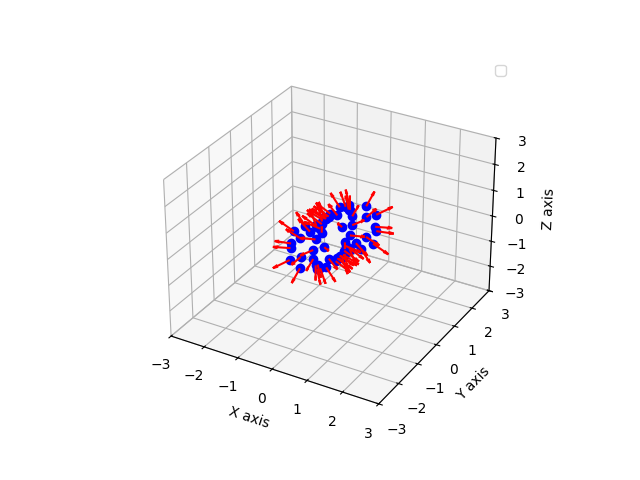

In [9]:
plot_poitns(Gamma2)

In [10]:
from gpbr.direct.common.source import SourcePoints2D, SourcePoints3D
from gpbr.direct.heat_equation.fundamental_sequence import fundamental_sequence_2d, FundamentalSequence, fundamental_sequence_3d
from gpbr.direct.heat_equation.helpers import dbu_3d, form_fs_matrix, form_fs_vector_2d, form_fs_vector_3d
from gpbr.direct.heat_equation.helpers import dbu_2d

from gpbr.direct.heat_equation.fundamental_sequence import FundamentalSequenceCoefs
from numpy.linalg import lstsq


def eval_for_g1(
        Gamma2: StarlikeSurface,
        Gamma2_source: StarlikeSurface,
        f1, f2,
        mfs_data,
        r1_func
    ):
    Gamma1 = StarlikeSurface.from_radial(mfs_data.collocation, r1_func)
    Gamma1_source = StarlikeSurface.from_radial(mfs_data.source_collocation, lambda theta,phi: ETA1*r1_func(theta,phi))
    src_cnt = Gamma1_source.collocation.n_phi * Gamma1_source.collocation.n_theta
    src_cnt+= Gamma2_source.collocation.n_phi * Gamma2_source.collocation.n_theta

    source_points = SourcePoints3D(src_cnt, mfs_data.eta1, mfs_data.eta2, Gamma1_source, Gamma2_source)


    fundamental_sequence_gamma1 = fundamental_sequence_3d(Gamma1, source_points, mfs_data)
    fundamental_sequence_gamma2 = fundamental_sequence_3d(Gamma2, source_points, mfs_data)
    PHI_MAT = form_fs_matrix(fundamental_sequence_gamma1, fundamental_sequence_gamma2)


    alpha_coeeff = np.empty((mfs_data.N+1, mfs_data.M), dtype=np.float64)
    alpha_coeeff[:] = np.nan
    fs_coefs = FundamentalSequenceCoefs(alpha_coeeff)
    for n in range(0, mfs_data.N+1):
        F = form_fs_vector_3d(n,
                            fundamental_sequence_gamma1,
                            fundamental_sequence_gamma2,
                            Gamma1,
                            Gamma2,
                            fs_coefs,
                            f1, f2, mfs_data)
        alpha_n = lstsq(PHI_MAT, F)[0]
        fs_coefs.alpha[n] = alpha_n.T

    du_vals = np.empty((mfs_data.N+1, mfs_data.M), dtype=np.float64)
    for n in range(0, N+1):
        for i, (x, nx) in enumerate(zip(Gamma2.points, Gamma2.normals)):
            du_vals[n, i] = dbu_3d(x, nx, n, source_points, fs_coefs, mfs_data)
    return du_vals

    

In [11]:
# def r1(theta, phi):
#      return np.ones_like(theta)*0.8
def r1(theta, phi):
     return 0.15*(0.6+np.sqrt(4.25+2*np.cos(3*theta)))

exact = eval_for_g1(Gamma2, Gamma2_source, f1, f2, mfs_data, r1)

In [12]:
exact

array([[-1.82887588e-09, -5.58184063e-10,  5.67900231e-10,
        -1.82440273e-09, -2.80891699e-09, -2.02099806e-09,
        -1.04938703e-09, -2.14789334e-10, -5.35864629e-11,
        -5.07953296e-10, -1.61382169e-09,  3.75589769e-08,
         3.75825230e-08, -1.71242431e-09, -3.67791482e-10,
         1.15561014e-09, -1.84671900e-10, -9.23992833e-10,
        -1.83104365e-09, -2.85036501e-09, -1.94470620e-09,
         1.46660885e-09, -1.04097679e-09, -4.07330435e-09,
        -1.80353170e-10, -2.75487353e-10, -3.24358650e-10,
        -1.77409130e-10,  5.53936067e-10, -1.94738922e-09,
         7.05024049e-10,  2.69048699e-10, -6.32626045e-11,
        -5.30240617e-11, -5.80399157e-11, -4.64420301e-11,
        -9.50291356e-11,  7.22868690e-10, -5.53243279e-11,
        -1.15952629e-09, -1.06843920e-10, -4.49143451e-11,
        -1.96328643e-12, -2.09515864e-11,  2.34854640e-11,
        -4.86601847e-11,  8.99664904e-11,  9.38044908e-10,
         5.61675539e-10,  2.64577642e-10, -8.86257396e-1

In [13]:
import matplotlib.pyplot as plt

def plot_surface(G1):
    fig_plot = plt.figure()
    ax_plot = fig_plot.add_subplot(111, projection='3d')

    rvals  = G1.rf(G1.collocation.theta_grid, G1.collocation.phi_grid) # We use numpy funtions, so we can do that way
    xx = rvals * np.sin(G1.collocation.theta_grid) * np.cos(G1.collocation.phi_grid)
    yy = rvals * np.sin(G1.collocation.theta_grid) * np.sin(G1.collocation.phi_grid)
    zz = rvals * np.cos(G1.collocation.theta_grid)

    # Plot the surface
    surf = ax_plot.plot_surface(xx, yy, zz, cmap='viridis')

    # Set axis labels
    ax_plot.set_xlabel('X axis')
    ax_plot.set_ylabel('Y axis')
    ax_plot.set_zlabel('Z axis')

    # Add grid
    ax_plot.grid(True)

    # Show the plot
    plt.show()
    # plt.close()


In [14]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

def plot_two_surfaces(G1, G2):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Surface 1
    rvals1 = G1.rf(G1.collocation.theta_grid, G1.collocation.phi_grid)
    x1 = rvals1 * np.sin(G1.collocation.theta_grid) * np.cos(G1.collocation.phi_grid)
    y1 = rvals1 * np.sin(G1.collocation.theta_grid) * np.sin(G1.collocation.phi_grid)
    z1 = rvals1 * np.cos(G1.collocation.theta_grid)
    ax.plot_surface(x1, y1, z1, cmap='viridis', alpha=0.7, label='Surface 1')

    # Surface 2
    rvals2 = G2.rf(G2.collocation.theta_grid, G2.collocation.phi_grid)
    x2 = rvals2 * np.sin(G2.collocation.theta_grid) * np.cos(G2.collocation.phi_grid)
    y2 = rvals2 * np.sin(G2.collocation.theta_grid) * np.sin(G2.collocation.phi_grid)
    z2 = rvals2 * np.cos(G2.collocation.theta_grid)
    ax.plot_surface(x2, y2, z2, cmap='plasma', alpha=0.7, label='Surface 2')
    # Surface 1
    # rvals1 = G1.rf(G1.collocation.theta_grid, G1.collocation.phi_grid)
    # x1 = rvals1 * np.sin(G1.collocation.theta_grid) * np.cos(G1.collocation.phi_grid)
    # y1 = rvals1 * np.sin(G1.collocation.theta_grid) * np.sin(G1.collocation.phi_grid)
    # z1 = rvals1 * np.cos(G1.collocation.theta_grid)
    # surf1 = ax.plot_surface(x1, y1, z1, cmap='viridis', alpha=0.7)
    # cbar1 = fig.colorbar(surf1, ax=ax, shrink=0.5, aspect=10, pad=0.1)
    # cbar1.set_label('Surface 1')

    # # Surface 2
    # rvals2 = G2.rf(G2.collocation.theta_grid, G2.collocation.phi_grid)
    # x2 = rvals2 * np.sin(G2.collocation.theta_grid) * np.cos(G2.collocation.phi_grid)
    # y2 = rvals2 * np.sin(G2.collocation.theta_grid) * np.sin(G2.collocation.phi_grid)
    # z2 = rvals2 * np.cos(G2.collocation.theta_grid)
    # surf2 = ax.plot_surface(x2, y2, z2, cmap='plasma', alpha=0.7)
    # cbar2 = fig.colorbar(surf2, ax=ax, shrink=0.5, aspect=10, pad=0.2)
    # cbar2.set_label('Surface 2')
    # Set axis labels
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

    # Show the plot
    plt.show()


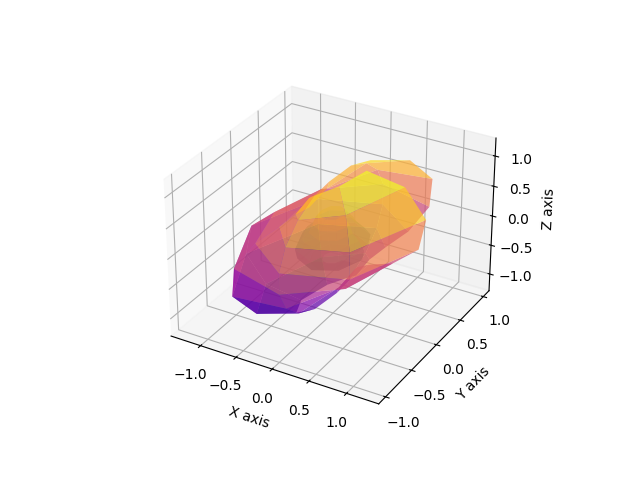

In [15]:
G1_plot = StarlikeSurface.from_radial(mfs_data.collocation, r1)
plot_two_surfaces(G1_plot, Gamma2)

In [16]:
from scipy import integrate

# def calc_l2_norm(ncoll, tn, exact, approx):
#     return np.sqrt(integrate.trapezoid(np.sum((approx-exact)**2, axis=1), tn)*(2*np.pi)/(ncoll))
def calc_l2_norm(theta_coll, phi_coll, t_coll, exact, approx):
    vals_reshapred = ((exact-approx)**2).reshape(-1, len(phi_coll), len(theta_coll))

    # First integrate along the theta direction (axis=2)
    theta_int = np.trapezoid(vals_reshapred, x=theta_coll, axis=2)

    # Then integrate the result along phi (axis=1), yielding one value per time slice
    time_vals = np.trapezoid(theta_int, x=phi_coll, axis=1)

    # Finally integrate in time using mfs_data.tn as the grid
    return np.trapezoid(time_vals, x=t_coll)


In [17]:
def feasable(ext_boundary, rfunc, rvals):
    thetas = np.linspace(0, 2*np.pi, 100)

    rvals_start = rfunc(thetas,np.zeros_like(thetas))
    rvals_stop = rfunc(thetas, 2*np.pi*np.ones_like(thetas))

    if not np.allclose(rvals_start, rvals_stop):
        return False

    if np.any(np.less(rvals, 0.0)):
        return False

    if np.any(np.greater_equal(rvals, ext_boundary)):
        return False
    
    return True

In [18]:
import random
from deap import creator, base, tools, algorithms, gp

In [19]:
import functools
import math, operator

pset = gp.PrimitiveSet("main", 2)
pset.addPrimitive(np.add, 2)
pset.addPrimitive(np.multiply, 2)
pset.addPrimitive(np.cos, 1)
pset.addPrimitive(np.sin, 1)
pset.addEphemeralConstant('rand', (np.random.rand, 1)[0])

pset.renameArguments(ARG0="theta")
pset.renameArguments(ARG1="phi")

In [20]:
import random
from deap import creator, base, tools, algorithms
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [21]:
toolbox = base.Toolbox()
# toolbox.register('expr', gp.genHalfAndHalf, pset=pset, min_=1, max_=3)
toolbox.register('expr', gp.genHalfAndHalf, pset=pset, min_=1, max_=5)
toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)
toolbox.register('compile', gp.compile, pset=pset)
# toolbox.register('evaluate', eval_for_g1, Gamma2=Gamma2, Gamma2_source=Gamma2_source, f1=f1, f2=f2, mfs_data=mfs_data)
toolbox.register('feasable', feasable, Gamma2_rvals)
toolbox.register('calc_normals', eval_for_g1, Gamma2, Gamma2_source, f1, f2, mfs_data)
toolbox.register('norm', calc_l2_norm, mfs_data.collocation.theta, mfs_data.collocation.phi, mfs_data.tn, exact)

toolbox.register('plot', plot_surface)

In [22]:
def evaluate(mfsd, tlb, ind):
    # print(ind)
    ind_compile = tlb.compile(expr=ind)
    ind_values = ind_compile(mfsd.collocation.theta_grid, mfsd.collocation.phi_grid)
    if not tlb.feasable(ind_compile, ind_values):
        return (100, )
    # if not tlb.feasable(ind_compile, ind_values):
    #     return (1e6, )

    g2_approx = tlb.calc_normals(ind_compile)
    return (toolbox.norm(g2_approx), )
toolbox.register('evaluate', evaluate, mfs_data, toolbox)

toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=6))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=6))
# toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
# toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

# random.seed(318)

pop = toolbox.population(n=50)
hof = tools.HallOfFame(1)

stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 40, stats=mstats,
                            halloffame=hof, verbose=True)

   	      	                        fitness                        	                      size                     
   	      	-------------------------------------------------------	-----------------------------------------------
gen	nevals	avg	gen	max	min        	nevals	std    	avg 	gen	max	min	nevals	std    
0  	50    	94 	0  	100	5.97226e-07	50    	23.7487	6.26	0  	43 	2  	50    	7.16327
1  	34    	88 	1  	100	5.97226e-07	34    	32.4962	5.82	1  	27 	2  	34    	5.22949
2  	26    	74 	2  	100	5.97226e-07	26    	43.8634	4.7 	2  	23 	1  	26    	3.73765
3  	30    	52 	3  	100	1.38705e-07	30    	49.96  	3.48	3  	12 	2  	30    	2.01236
4  	25    	32 	4  	100	5.97226e-07	25    	46.6476	2.86	4  	8  	1  	25    	1.37128
5  	29    	32 	5  	100	5.97226e-07	29    	46.6476	3.16	5  	9  	1  	29    	1.77042
6  	22    	24 	6  	100	5.97226e-07	22    	42.7083	2.9 	6  	8  	2  	22    	1.43178
7  	28    	26 	7  	100	5.97226e-07	28    	43.8634	3   	7  	7  	2  	28    	1.26491
8  	31    	20 	8  	100	5.97226e-

In [27]:
print(hof[0])

multiply(sin(sin(sin(0.5560628474116072))), cos(0.5422975257978424))


In [24]:
for ind in pop:
    print(ind, ind.fitness.values)

multiply(0.5560628474116072, sin(cos(sin(theta)))) (np.float64(1.3090355459624024e-07),)
multiply(sin(cos(0.13664354705604465)), sin(cos(sin(theta)))) (100.0,)
multiply(0.5560628474116072, sin(cos(sin(0.5560628474116072)))) (np.float64(1.7100510003060233e-07),)
multiply(0.5560628474116072, sin(cos(sin(theta)))) (np.float64(1.3090355459624024e-07),)
multiply(0.5560628474116072, sin(cos(sin(theta)))) (np.float64(1.3090355459624024e-07),)
multiply(0.5560628474116072, sin(cos(sin(theta)))) (np.float64(1.3090355459624024e-07),)
multiply(0.5560628474116072, sin(sin(cos(sin(theta))))) (np.float64(4.584411148670424e-07),)
multiply(0.5560628474116072, sin(cos(sin(theta)))) (np.float64(1.3090355459624024e-07),)
multiply(0.5560628474116072, sin(cos(sin(theta)))) (np.float64(1.3090355459624024e-07),)
multiply(0.5560628474116072, sin(cos(sin(theta)))) (np.float64(1.3090355459624024e-07),)
multiply(0.5560628474116072, sin(cos(sin(theta)))) (np.float64(1.3090355459624024e-07),)
multiply(0.55606284741

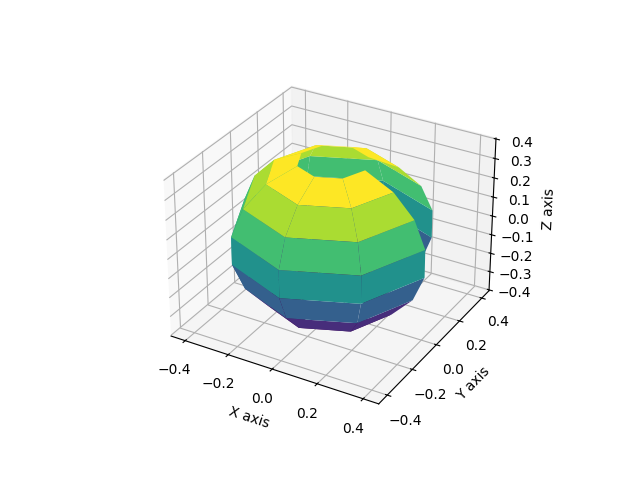

In [25]:
G1_test = StarlikeSurface.from_radial(mfs_data.collocation, toolbox.compile(expr=hof[0]))
toolbox.plot(G1_test)

In [26]:
assert False

AssertionError: 

#TODO: add to tests

In [ ]:
def r1(theta, phi):
     return np.ones_like(theta)*0.8

def dr1(theta, phi):
     return np.zeros_like(theta)

# exact = eval_for_g1(Gamma2, Gamma2_source, f1, f2, mfs_data, r1)

In [ ]:
from gpbr.direct.common.boundary import StarlikeSurface

Gamma1 = StarlikeSurface.from_radial_with_derivative(mfs_data.collocation, r1, dr2)
Gamma2 = StarlikeSurface.from_radial_with_derivative(mfs_data.collocation, r2, dr2)

In [ ]:
Gamma1_source = StarlikeSurface.from_radial(mfs_data.source_collocation, lambda tetha,phi: ETA1*r1(tetha,phi))
Gamma2_source = StarlikeSurface.from_radial(mfs_data.source_collocation, lambda tetha,phi: ETA2*r2(tetha,phi))

In [ ]:
from gpbr.direct.common.source import SourcePoints3D
source_points = SourcePoints3D(mfs_data.M, mfs_data.eta1, mfs_data.eta2, Gamma1_source, Gamma2_source)

In [ ]:
from gpbr.direct.heat_equation.fundamental_sequence import fundamental_sequence_3d

fundamental_sequence_gamma1 = fundamental_sequence_3d(Gamma1, source_points, mfs_data)
fundamental_sequence_gamma2 = fundamental_sequence_3d(Gamma2, source_points, mfs_data)

In [ ]:
from gpbr.direct.heat_equation.helpers import form_fs_matrix, form_fs_vector_2d
PHI_MAT = form_fs_matrix(fundamental_sequence_gamma1, fundamental_sequence_gamma2)
PHI_MAT.shape

(256, 128)

In [ ]:
PHI_MAT

array([[5.38191359e-06, 3.89287792e-06, 1.60531130e-06, ...,
        4.42817304e-03, 3.35871085e-03, 3.03455855e-03],
       [3.89287792e-06, 5.38191359e-06, 3.89287792e-06, ...,
        3.49111526e-03, 3.13757461e-03, 3.35871085e-03],
       [1.60531130e-06, 3.89287792e-06, 5.38191359e-06, ...,
        3.25975296e-03, 3.49111526e-03, 4.42817304e-03],
       ...,
       [3.76500734e-09, 3.76629014e-08, 4.84521331e-07, ...,
        1.00671825e-04, 1.86872855e-04, 3.81834806e-04],
       [5.09339797e-10, 3.55088980e-09, 3.76629014e-08, ...,
        1.86872855e-04, 3.81834806e-04, 8.00080863e-04],
       [1.16363186e-10, 5.09339797e-10, 3.76500734e-09, ...,
        3.81834806e-04, 8.00080863e-04, 1.56023790e-03]])

In [ ]:
from gpbr.direct.heat_equation.fundamental_sequence import FundamentalSequenceCoefs

alpha_coeeff = np.empty((N+1, M), dtype=np.float64)
alpha_coeeff[:] = np.nan
fs_coefs = FundamentalSequenceCoefs(alpha_coeeff)
from gpbr.direct.heat_equation.helpers import form_fs_vector_3d
from numpy.linalg import lstsq
for n in range(0, N+1):
    F = form_fs_vector_3d(n,
                          fundamental_sequence_gamma1,
                          fundamental_sequence_gamma2,
                          Gamma1,
                          Gamma2,
                          fs_coefs,
                          f1, f2, mfs_data)
    alpha_n = lstsq(PHI_MAT, F)[0]
    fs_coefs.alpha[n] = alpha_n.T
    print(fs_coefs.alpha)

[[ 2.00621533e-06 -7.32196146e-07  1.03285561e-06 ... -3.50082709e-12
  -1.99348253e-11  1.11746348e-10]
 [            nan             nan             nan ...             nan
              nan             nan]
 [            nan             nan             nan ...             nan
              nan             nan]
 ...
 [            nan             nan             nan ...             nan
              nan             nan]
 [            nan             nan             nan ...             nan
              nan             nan]
 [            nan             nan             nan ...             nan
              nan             nan]]
[[ 2.00621533e-06 -7.32196146e-07  1.03285561e-06 ... -3.50082709e-12
  -1.99348253e-11  1.11746348e-10]
 [ 1.11568169e-03 -1.48348634e-04 -1.75746870e-04 ...  2.08745368e-09
  -5.31851706e-09  4.42036068e-07]
 [            nan             nan             nan ...             nan
              nan             nan]
 ...
 [            nan             nan           

In [ ]:
from gpbr.direct.common.boundary import Point3D
test_points = [Point3D(0.0, 0.98, 0.0), Point3D(1.0, -0.73, 0.0), Point3D(0.0, 0.51, 0.54), Point3D(0.0, -0.501, 0.52), Point3D(-1.11, 0.0, -0.75), Point3D(0.0, 0.0, -1.0)]

In [ ]:
from gpbr.direct.heat_equation.helpers import u_3d
for n in range(0, N+1):
    print(f'N={n}')
    for p in test_points:
        u_approx = u_3d(p, n, source_points, fs_coefs, mfs_data)
        u_exact = u3de(p, mfs_data.tn[n])
        print(f'Difference: {abs(u_approx - u_exact)}')
        # print(f'u_approx={u_approx}, u_exact={u_exact}')

N=0
Difference: 2.4526577686550493e-09
Difference: 2.720280454453859e-12
Difference: 5.0823509609174895e-11
Difference: 4.2223731746026977e-13
Difference: 3.173334129595302e-12
Difference: 4.460142988993429e-12
N=1
Difference: 3.652231024107005e-06
Difference: 5.03904405594703e-10
Difference: 1.737037547099781e-07
Difference: 1.2242934703796507e-09
Difference: 2.82418266215802e-10
Difference: 3.231656190779176e-09
N=2
Difference: 8.755932214348446e-06
Difference: 9.530715456938888e-09
Difference: 1.8255604309859783e-06
Difference: 1.3157904053872034e-08
Difference: 9.620148205570264e-08
Difference: 6.292033145968017e-08
N=3
Difference: 2.7769527901671458e-05
Difference: 1.2441536283414855e-07
Difference: 2.658567189765343e-07
Difference: 3.677654071087691e-08
Difference: 5.57160337284949e-07
Difference: 4.0812260431480996e-07
N=4
Difference: 8.572350932588963e-05
Difference: 5.546371805896187e-07
Difference: 9.641381741798963e-06
Difference: 1.4396849994378274e-08
Difference: 5.9061549

In [ ]:
def du3de_vec(xp, t):
    # '-0.125*x1*exp((-x1**2/4 - x3**2/4 - (x2 - 4)**2/4)/t)/(pi*t**2)'
    # 0.25*(2 - x2/2)*exp((-x1**2/4 - x3**2/4 - (x2 - 4)**2/4)/t)/(pi*t**2)
    # -0.125*x3*exp((-x1**2/4 - x3**2/4 - (x2 - 4)**2/4)/t)/(pi*t**2)


    x1=xp.x
    x2=xp.y
    x3=xp.z

    return Point3D(
        -0.125*x1*np.exp((-x1**2/4 - x3**2/4 - (x2 - 4)**2/4)/t)/(np.pi*t**2),
        0.25*(2 - x2/2)*np.exp((-x1**2/4 - x3**2/4 - (x2 - 4)**2/4)/t)/(np.pi*t**2),
        -0.125*x3*np.exp((-x1**2/4 - x3**2/4 - (x2 - 4)**2/4)/t)/(np.pi*t**2)
    )


In [ ]:
from gpbr.direct.heat_equation.helpers import dbu_3d
for n in range(0, N+1):
    print(f'N={n}')
    norms = []
    for x, nx in zip(Gamma1.points, Gamma1.normals):
        du_approx = dbu_3d(x, nx, n, source_points, fs_coefs, mfs_data)
        du_e_vec = du3de_vec(x, mfs_data.tn[n])
        du_exact = du_e_vec.x*nx.x + du_e_vec.y*nx.y + du_e_vec.z*nx.z
        norms.append(abs(du_approx - du_exact))
    print(f'Max difference: {max(norms)}')
    # print(f'Max difference: {np.linalg.norm(norms)}')

N=0
Max difference: 1.1820617460667114e-08
N=1
Max difference: 2.080259749625307e-05
N=2
Max difference: 7.668767694624679e-05
N=3
Max difference: 0.00015240817352494358
N=4
Max difference: 0.00057538596965829
N=5
Max difference: 0.000979498366367482
N=6
Max difference: 0.0013419670149876078
N=7
Max difference: 0.0016339373835404332
N=8
Max difference: 0.0018510743805146973
N=9
Max difference: 0.0020043242076912653
N=10
Max difference: 0.0020973181586934012


In [ ]:
assert False

AssertionError: 

In [ ]:
phig =mfs_data.collocation.phi_grid
thetag = mfs_data.collocation.theta_grid

In [ ]:
r2vals = r2(thetag, phig)
xx = r2vals*np.sin(thetag)*np.cos(phig)
yy = r2vals*np.sin(thetag)*np.sin(phig)
zz = r2vals*np.cos(thetag)

In [ ]:
xx.shape

(8, 4)

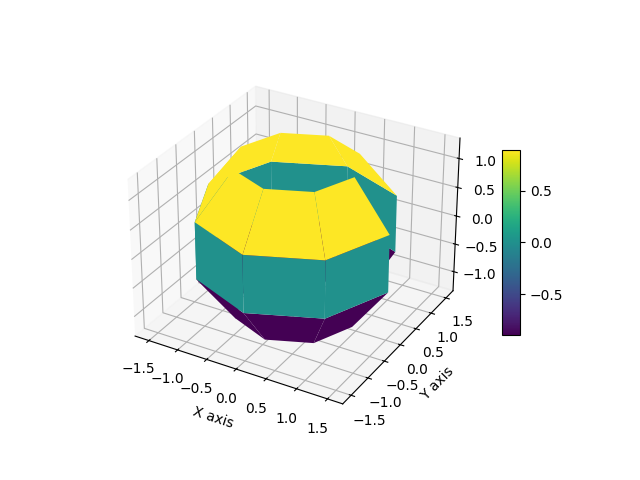

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Example data for xx, yy, zz


# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(xx, yy, zz, cmap='viridis')

# Add a color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

# Set labels
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

# Show the plot
plt.show()

In [ ]:
sphere_base = 

In [ ]:
mfs_data.collocation.phi_grid

array([[0.78539816, 0.78539816, 0.78539816, 0.78539816],
       [1.57079633, 1.57079633, 1.57079633, 1.57079633],
       [2.35619449, 2.35619449, 2.35619449, 2.35619449],
       [3.14159265, 3.14159265, 3.14159265, 3.14159265],
       [3.92699082, 3.92699082, 3.92699082, 3.92699082],
       [4.71238898, 4.71238898, 4.71238898, 4.71238898],
       [5.49778714, 5.49778714, 5.49778714, 5.49778714],
       [6.28318531, 6.28318531, 6.28318531, 6.28318531]])

In [ ]:
mfs_data.collocation.theta_grid

array([[0.62831853, 1.25663706, 1.88495559, 2.51327412],
       [0.62831853, 1.25663706, 1.88495559, 2.51327412],
       [0.62831853, 1.25663706, 1.88495559, 2.51327412],
       [0.62831853, 1.25663706, 1.88495559, 2.51327412],
       [0.62831853, 1.25663706, 1.88495559, 2.51327412],
       [0.62831853, 1.25663706, 1.88495559, 2.51327412],
       [0.62831853, 1.25663706, 1.88495559, 2.51327412],
       [0.62831853, 1.25663706, 1.88495559, 2.51327412]])

In [ ]:
mfs_data.collocation

In [ ]:
rf(collocation.theta_grid, collocation.phi_grid)

In [ ]:
from gpbr.direct.common.boundary import StarlikeSurface

Gamma1 = StarlikeCurve.from_radial_with_derivative(mfs_data.collocation, r1, dr1)
Gamma2 = StarlikeCurve.from_radial_with_derivative(mfs_data.collocation, r2, dr2)

In [ ]:
Gamma1_source = StarlikeCurve.from_radial(mfs_data.source_collocation, lambda s: ETA1*r1(s))
Gamma2_source = StarlikeCurve.from_radial(mfs_data.source_collocation, lambda s: ETA2*r2(s))

In [ ]:
from gpbr.direct.common.source import SourcePoints2D
source_points = SourcePoints2D(Gamma1_source.collocation.n+Gamma2_source.collocation.n, mfs_data.eta1, mfs_data.eta2, Gamma1_source, Gamma2_source)

In [ ]:
## Plot
import matplotlib.pyplot as plt
def plot_normals(G2: StarlikeSurface):
    fig_plot, ax_plot = plt.subplots()
    g1_x, g1_y = G1.raw_points()
    g2_x, g2_y = G2.raw_points()
    ax_plot.plot(g1_x, g1_y, 'b--')
    ax_plot.plot(g2_x, g2_y, 'r--')

    for sp in source:
        ax_plot.plot(sp.x, sp.y, 'bo')

    # Plot normal vectors
    for p, n in zip(G1.points, G1.normals):
        ax_plot.quiver(p.x, p.y, n.x, n.y, color='blue', scale=15)

    for p, n in zip(G2.points, G2.normals):
        ax_plot.quiver(p.x, p.y, n.x, n.y, color='red', scale=15)

    ax_plot.axis('equal')
    plt.grid()
    plt.show()
    plt.close()

In [ ]:
plot_2d(Gamma1, Gamma2, source_points)

In [ ]:
from gpbr.direct.common.boundary import Point2D
from gpbr.direct.common.distance import point_distance
def u2de(xp, t):
    point = Point2D(0,4)
    dist =point_distance(point, xp)
    return 1/4/np.pi/t*np.exp(-dist**2/4/t)
    

In [ ]:
from gpbr.direct.common.boundary import Point2D

def f1(x: Point2D , t: float) -> float:
    return u2de(x, t)

def f2(x: Point2D, t: float) -> float:
    return u2de(x, t)

In [ ]:
from gpbr.direct.heat_equation.common import MFSConfig
T = 1 # final time
N = 10 # N+1=10 time points
M = 16 # number of collocation and points
ETA1 = 0.5
ETA2 = 2.0
config = MFSConfig(
    N=N,
    n_coll=M,
    n_source=M,
    T=T,
    eta1=ETA1,
    eta2=ETA2,
    f1=f1,
    f2=f2
)


In [ ]:
from gpbr.direct.heat_equation.helpers import precalculate_mfs_data
mfs_data = precalculate_mfs_data(config)

In [ ]:
def r2(theta, phi):
    return 2+np.sqrt(4.25+3*np.cos(3*theta))

def dr2(s):
    return 0

In [ ]:
2 + sqrt(4.25+3*cos(3*theta))

In [ ]:
from gpbr.direct.common.boundary import StarlikeCurve, starlike_circle_base, starlike_curve
Gamma2 = StarlikeCurve.from_radial_with_derivative(mfs_data.collocation, r2, dr2)
Gamma2_source = StarlikeCurve.from_radial(mfs_data.source_collocation, lambda s: ETA2*r2(s))

In [ ]:
from gpbr.direct.common.source import SourcePoints2D
from gpbr.direct.heat_equation.fundamental_sequence import fundamental_sequence_2d, FundamentalSequence
from gpbr.direct.heat_equation.helpers import form_fs_matrix, form_fs_vector_2d
from gpbr.direct.heat_equation.helpers import dbu_2d

from gpbr.direct.heat_equation.fundamental_sequence import FundamentalSequenceCoefs
from numpy.linalg import lstsq


def eval_for_g1(
        Gamma2: StarlikeCurve,
        Gamma2_source: StarlikeCurve,
        f1, f2,
        mfs_data,
        r1_func
    ):
    Gamma1 = StarlikeCurve.from_radial(mfs_data.collocation, r1_func)
    Gamma1_source = StarlikeCurve.from_radial(mfs_data.source_collocation, lambda s: ETA1*r1_func(s))
    source_points = SourcePoints2D(Gamma1_source.collocation.n+Gamma2_source.collocation.n, mfs_data.eta1, mfs_data.eta2, Gamma1_source, Gamma2_source)


    fundamental_sequence_gamma1 = fundamental_sequence_2d(Gamma1, source_points, mfs_data)
    fundamental_sequence_gamma2 = fundamental_sequence_2d(Gamma2, source_points, mfs_data)
    PHI_MAT = form_fs_matrix(fundamental_sequence_gamma1, fundamental_sequence_gamma2)


    alpha_coeeff = np.empty((mfs_data.N+1, mfs_data.M), dtype=np.float64)
    alpha_coeeff[:] = np.nan
    fs_coefs = FundamentalSequenceCoefs(alpha_coeeff)
    for n in range(0, mfs_data.N+1):
        F = form_fs_vector_2d(n,
                            fundamental_sequence_gamma1,
                            fundamental_sequence_gamma2,
                            Gamma1,
                            Gamma2,
                            fs_coefs,
                            f1, f2, mfs_data)
        alpha_n = lstsq(PHI_MAT, F)[0]
        fs_coefs.alpha[n] = alpha_n.T

    du_vals = np.empty((mfs_data.N+1, mfs_data.M), dtype=np.float64)
    for n in range(0, N+1):
        for i, (x, nx) in enumerate(zip(Gamma2.points, Gamma2.normals)):
            du_vals[n, i] = dbu_2d(x, nx, n, source_points, fs_coefs, mfs_data)
    return du_vals

    

In [ ]:
# def r1(s):
#     return 0.8
def r1(s):
    return np.sqrt(np.cos(s)**2 + np.sin(s)**2/4)

exact = eval_for_g1(Gamma2, Gamma2_source, f1, f2, mfs_data, r1)

In [ ]:
import matplotlib.pyplot as plt

def plot_g1(G1):
    fig_plot, ax_plot = plt.subplots()
    g1_x, g1_y = G1.raw_points()
    ax_plot.plot(g1_x, g1_y, 'b--')

    ax_plot.axis('equal')
    plt.grid()
    plt.show()
    plt.close()


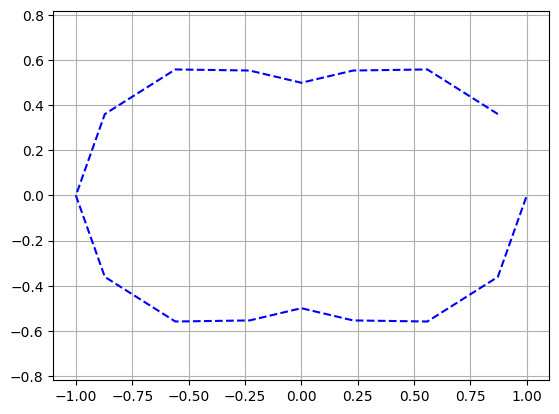

In [ ]:
G1_plot = StarlikeCurve.from_radial(mfs_data.collocation, r1)
plot_g1(G1_plot)

In [ ]:
from scipy import integrate

def calc_l2_norm(ncoll, tn, exact, approx):
    return np.sqrt(integrate.trapezoid(np.sum((approx-exact)**2, axis=1), tn)*(2*np.pi)/(ncoll))


In [ ]:
def feasable(ext_boundary, rfunc, rvals):
    if abs(rfunc(0) - rfunc(2*np.pi)) > 1e-6:
        return False

    if np.any(np.less(rvals, 0.0)):
        return False

    if np.any(np.greater_equal(rvals, ext_boundary)):
        return False
    
    return True

In [ ]:
import random
from deap import creator, base, tools, algorithms, gp

In [ ]:
import functools
import math, operator

pset = gp.PrimitiveSet("main", 1)
pset.addPrimitive(np.add, 2)
pset.addPrimitive(np.multiply, 2)
pset.addPrimitive(np.cos, 1)
pset.addPrimitive(np.sin, 1)
pset.addEphemeralConstant('rand', (np.random.rand, 1)[0])

pset.renameArguments(ARG0="s")

In [ ]:
import random
from deap import creator, base, tools, algorithms
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [ ]:
toolbox = base.Toolbox()
# toolbox.register('expr', gp.genHalfAndHalf, pset=pset, min_=1, max_=3)
toolbox.register('expr', gp.genHalfAndHalf, pset=pset, min_=1, max_=5)
toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)
toolbox.register('compile', gp.compile, pset=pset)

In [ ]:
# toolbox.register('evaluate', eval_for_g1, Gamma2=Gamma2, Gamma2_source=Gamma2_source, f1=f1, f2=f2, mfs_data=mfs_data)
toolbox.register('feasable', feasable, 1.6)
toolbox.register('calc_normals', eval_for_g1, Gamma2, Gamma2_source, f1, f2, mfs_data)
toolbox.register('norm', calc_l2_norm, mfs_data.M, mfs_data.tn, exact)
toolbox.register('plot', plot_g1)

In [ ]:
def evaluate(mfsd, tlb, ind):
    # print(ind)
    ind_compile = tlb.compile(expr=ind)
    ind_values = ind_compile(mfsd.collocation.theta)
    if not toolbox.feasable(ind_compile, ind_values):
        return (1e6, )

    g2_approx = toolbox.calc_normals(ind_compile)
    return (toolbox.norm(g2_approx), )

In [ ]:
toolbox.register('evaluate', evaluate, mfs_data, toolbox)


In [ ]:
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [ ]:

# random.seed(318)

pop = toolbox.population(n=50)
hof = tools.HallOfFame(1)

stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 40, stats=mstats,
                            halloffame=hof, verbose=True)

   	      	                       fitness                        	                      size                     
   	      	------------------------------------------------------	-----------------------------------------------
gen	nevals	avg   	gen	max  	min        	nevals	std   	avg 	gen	max	min	nevals	std    
0  	50    	720000	0  	1e+06	4.34443e-06	50    	448999	8.56	0  	33 	2  	50    	8.47151
1  	32    	460000	1  	1e+06	4.34443e-06	32    	498397	6.68	1  	33 	1  	32    	7.22064
2  	30    	260000	2  	1e+06	4.34443e-06	30    	438634	5.28	2  	30 	2  	30    	5.12656
3  	21    	40000 	3  	1e+06	5.03397e-07	21    	195959	3.62	3  	8  	2  	21    	1.73078
4  	23    	80000 	4  	1e+06	5.03397e-07	23    	271293	3.2 	4  	8  	2  	23    	1.23288
5  	30    	60000 	5  	1e+06	5.03397e-07	30    	237487	3.1 	5  	5  	1  	30    	0.984886
6  	22    	100000	6  	1e+06	5.03397e-07	22    	300000	3.18	6  	5  	1  	22    	0.84119 
7  	28    	140000	7  	1e+06	5.03397e-07	28    	346987	3.32	7  	7  	2  	28    	0.96

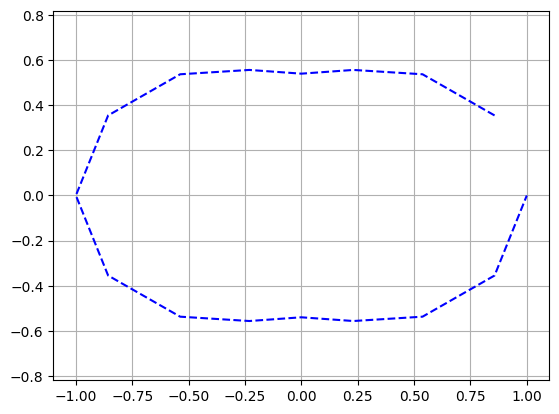

In [ ]:
G1_test = StarlikeCurve.from_radial(mfs_data.collocation, toolbox.compile(expr=hof[0]))
toolbox.plot(G1_test)

In [ ]:
print(hof[0])

cos(sin(s))


In [ ]:
assert False

AssertionError: 

In [ ]:
import matplotlib.pyplot as plt

def plot_g1(G1):
    fig_plot, ax_plot = plt.subplots()
    g1_x, g1_y = G1.raw_points()
    ax_plot.plot(g1_x, g1_y, 'b--')

    ax_plot.axis('equal')
    plt.grid()
    plt.show()
    plt.close()

In [ ]:
toolbox.register('plot', plot_g1)

add(sin(cos(sin(sin(s)))), sin(add(sin(add(0.35154652343713955, s)), cos(multiply(s, s)))))
multiply(s, s)
multiply(sin(multiply(cos(sin(s)), cos(sin(0.6149477194972331)))), cos(multiply(multiply(sin(0.5180465030210641), sin(0.04959337865745339)), add(cos(0.7573324363233912), cos(s)))))
1.552991909080186e-05


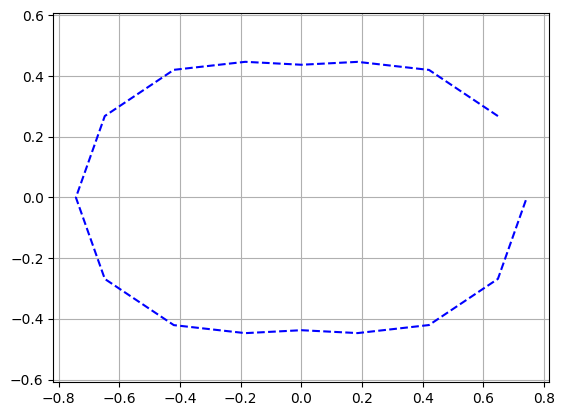

---------------------------------------------------------------------------
sin(add(0.12037073509728358, s))
multiply(cos(sin(sin(s))), sin(cos(multiply(0.9350739033069126, s))))
multiply(0.30813773366873853, multiply(s, 0.5089915652036325))
sin(multiply(sin(sin(s)), cos(sin(0.7359000640387753))))
sin(cos(s))
cos(cos(sin(multiply(add(s, 0.3677084696698829), cos(0.10533105821766908)))))
multiply(cos(sin(add(add(0.2638132373849562, s), add(0.10490388560245512, s)))), add(cos(multiply(cos(s), cos(0.2460418822655981))), sin(cos(cos(0.014921757807564773)))))
4.5364073068500464e-05


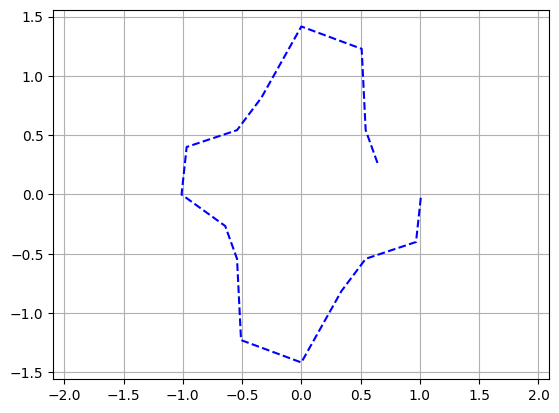

---------------------------------------------------------------------------
cos(multiply(s, 0.3100523103549573))
sin(cos(cos(0.9222110602541755)))
5.2655661052626634e-06


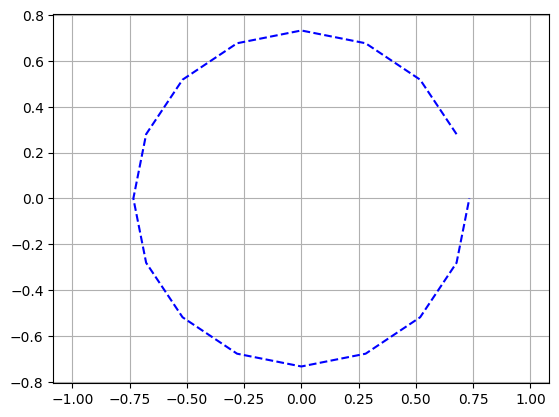

---------------------------------------------------------------------------
add(cos(cos(multiply(s, s))), cos(cos(add(s, s))))
add(add(0.2611738351753442, 0.6121529504174111), cos(0.9793584348178721))
0.0005761421736524605


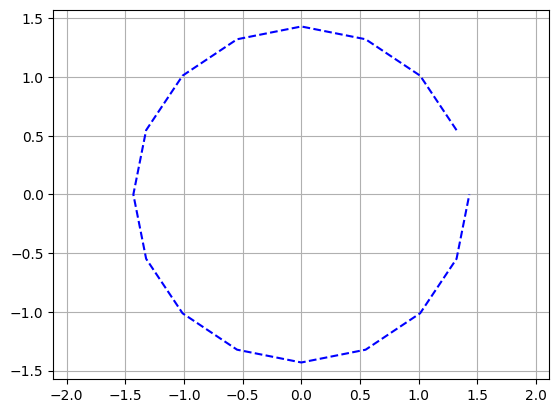

---------------------------------------------------------------------------
add(cos(add(cos(s), multiply(s, s))), sin(sin(sin(s))))
multiply(multiply(add(cos(multiply(0.6669384554290868, s)), add(sin(s), add(s, s))), add(add(multiply(0.5176719646519707, 0.39932071098154875), sin(0.5059969639592864)), sin(add(s, 0.5311130120151062)))), add(cos(add(add(s, s), add(0.3360314517930926, 0.9762579352641558))), cos(multiply(add(s, s), multiply(s, s)))))
sin(s)
sin(cos(s))
sin(0.2247570555588566)
1.8560087625195784e-05


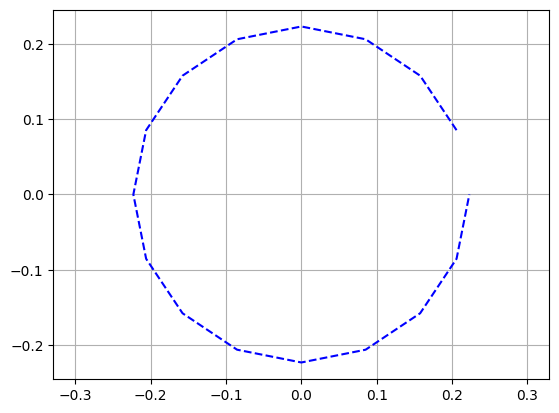

---------------------------------------------------------------------------
cos(sin(sin(multiply(0.07063018514010444, s))))
multiply(0.23193011712783884, s)
multiply(add(sin(add(add(0.2869928392479212, 0.38413556245851455), add(0.2552412992449399, 0.17387039993720643))), cos(add(add(0.32301124823684824, 0.8400653216479955), multiply(0.7439388735838811, s)))), add(cos(sin(multiply(0.2913194259331081, 0.5486672013021568))), cos(cos(add(s, 0.1048308758173726)))))
sin(s)
add(sin(sin(0.9371961008138076)), add(cos(s), add(0.7380477674822958, s)))
add(sin(multiply(cos(add(0.8658354152708848, s)), add(multiply(0.569574066766192, s), sin(s)))), multiply(sin(sin(sin(0.3227334007824313))), cos(multiply(cos(0.8650242575779415), add(s, s)))))
multiply(sin(s), sin(s))
7.204022212542782e-06


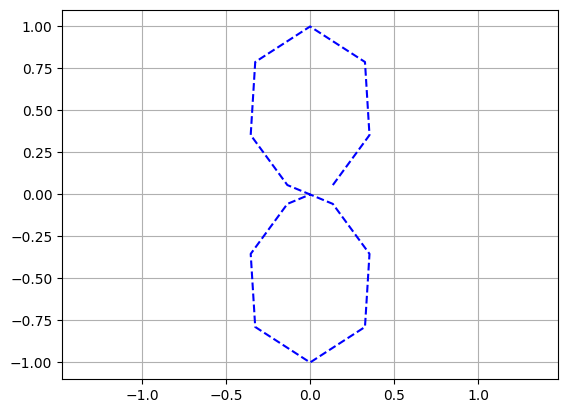

---------------------------------------------------------------------------
sin(s)
sin(s)
cos(0.11345235045793656)
2.6386411681343252e-05


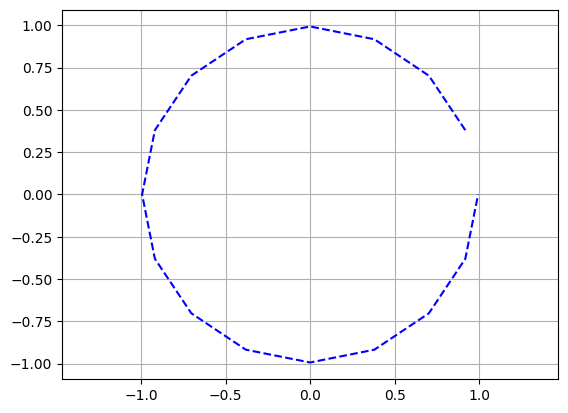

---------------------------------------------------------------------------
sin(s)
sin(s)
sin(multiply(cos(0.296752823510109), multiply(multiply(s, 0.686582019226399), add(s, 0.3039228594036216))))
multiply(sin(sin(add(add(0.361565926237704, s), sin(s)))), sin(add(cos(add(s, 0.8748001286585986)), add(multiply(0.7717659769299718, 0.4902974811827907), cos(0.8221172444727883)))))
add(0.18616114508721093, multiply(s, 0.3590137773722407))
add(sin(cos(s)), cos(multiply(0.23563309516326048, s)))
multiply(s, s)
add(0.09660511852276721, sin(cos(0.866260916398649)))
7.40417016959267e-06


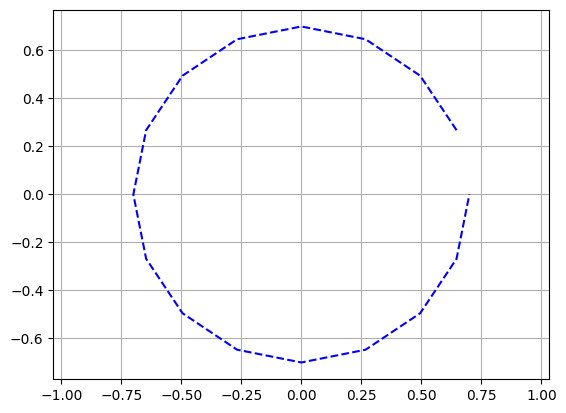

---------------------------------------------------------------------------
add(cos(sin(0.9508048925802135)), s)
multiply(add(sin(s), add(s, 0.493843121351071)), add(add(s, s), sin(0.30927110591223195)))
multiply(sin(s), multiply(s, 0.9787066940900057))
sin(multiply(s, s))
add(cos(s), add(sin(s), sin(add(s, 0.7970850234640509))))
cos(s)
cos(0.7130791641665306)
3.5984995114309576e-06


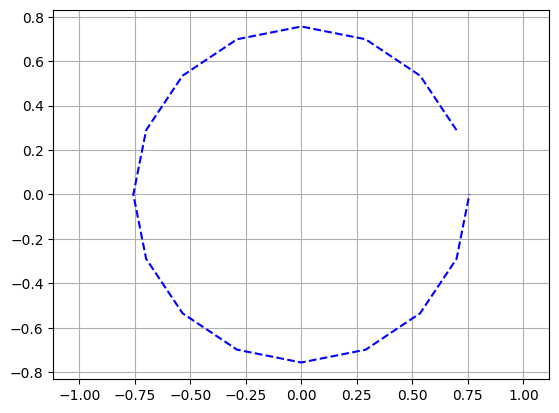

---------------------------------------------------------------------------
multiply(add(multiply(cos(cos(0.3772565565794904)), cos(multiply(0.052206353644035475, 0.4877777538655037))), sin(cos(cos(s)))), multiply(add(cos(cos(0.4040309467767673)), cos(multiply(0.16730545174759037, s))), add(sin(cos(0.8932669594490584)), add(add(0.057518431890260624, s), cos(0.74848928074168)))))
add(cos(s), multiply(s, s))
multiply(add(multiply(sin(sin(0.13951586845256347)), add(cos(0.5376215812145829), sin(s))), add(sin(sin(s)), add(sin(s), cos(s)))), sin(multiply(sin(multiply(s, 0.8373884974810512)), cos(add(s, s)))))
cos(sin(sin(0.032811890774947394)))
2.7575424503907682e-05


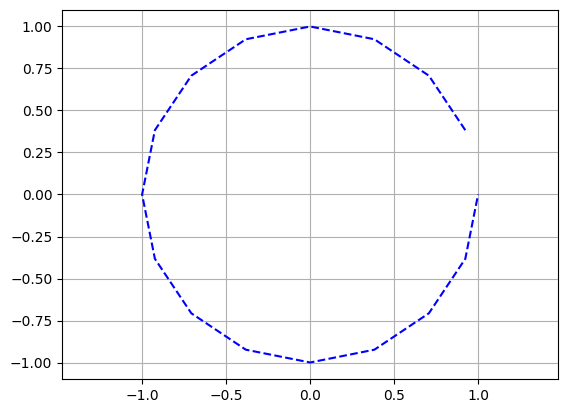

---------------------------------------------------------------------------
cos(s)
add(sin(s), cos(s))


In [ ]:
from scipy import integrate
for ind in toolbox.population(n=50):
    ind_compile = toolbox.compile(expr=ind)
    ind_values = ind_compile(mfs_data.collocation.theta)
    print(ind)

    if not toolbox.feasable(ind_compile, ind_values):
        continue

    G1_test = StarlikeCurve.from_radial(mfs_data.collocation, ind_compile)
    g1_approx = toolbox.evaluate(ind_compile)
    print(toolbox.norm(g1_approx))
    toolbox.plot(G1_test)
    print('---------------------------------------------------------------------------')

In [ ]:
assert Fals

NameError: name 'Fals' is not defined

In [ ]:
import numpy as np

# Define the parametric function r(theta)
def r(theta):
    return np.sin(theta) + np.sin(0.11352607057693409)
    return np.sin(np.cos(2*theta))
    # sin(cos(add(s, s)))

    # Example: r(theta) = 1 + 0.5 * np.sin(5 * theta)
    return 1 + 0.5 * np.sin(5 * theta)

# Define the number of samples
num_samples = 1000

# Generate theta values
theta_values = np.linspace(0, 2 * np.pi, num_samples)

# Convert to Cartesian coordinates
x_values = r(theta_values) * np.cos(theta_values)
y_values = r(theta_values) * np.sin(theta_values)

# Check for intersections
tolerance = 1e-6
intersections = []

for i in range(num_samples):
    for j in range(i + 1, num_samples):
        if np.abs(x_values[i] - x_values[j]) < tolerance and np.abs(y_values[i] - y_values[j]) < tolerance:
            intersections.append((theta_values[i], theta_values[j]))

print("Self-intersections:", intersections)

Self-intersections: [(np.float64(0.0), np.float64(6.283185307179586))]


In [ ]:
import sympy as sp

# Define the parameter
theta = sp.symbols('theta')

# Define the parametric equations for the starlike curve
r = sp.Function('r')(theta)
x = r * sp.cos(theta)
y = r * sp.sin(theta)

# Define another parameter for comparison
theta2 = sp.symbols('theta2')

# Equations for self-intersection
eq1 = sp.Eq(x.subs(theta, theta), x.subs(theta, theta2))
eq2 = sp.Eq(y.subs(theta, theta), y.subs(theta, theta2))

print("Equation 1:", eq1)
print("Equation 2:", eq2)

Equation 1: Eq(r(theta)*cos(theta), r(theta2)*cos(theta2))
Equation 2: Eq(r(theta)*sin(theta), r(theta2)*sin(theta2))


In [ ]:
ind = toolbox.individual()
print(ind)

sin(cos(cos(-0.12333206376883887)))


In [ ]:
toolbox.compile(ind)(0)

0.5198524963998898

In [ ]:
G1_test = StarlikeCurve.from_radial(mfs_data.collocation, toolbox.compile(ind))

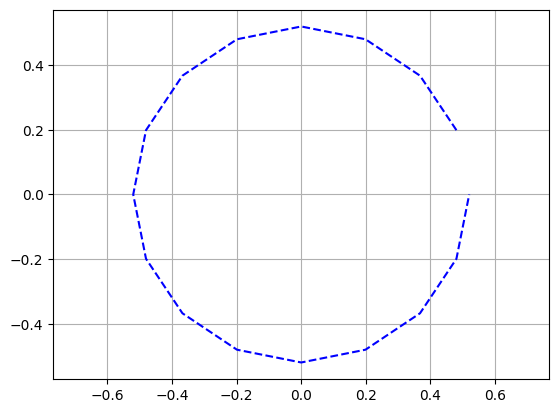

In [ ]:
import matplotlib.pyplot as plt

fig_plot, ax_plot = plt.subplots()
g1_x, g1_y = G1_test.raw_points()
ax_plot.plot(g1_x, g1_y, 'b--')

ax_plot.axis('equal')
plt.grid()
plt.show()
plt.close()

In [ ]:
toolbox.evaluate(toolbox.compile(ind))[0]

array([-9.05432844e-09, -3.93603090e-08,  1.10901463e-07,  5.08693740e-07,
        1.10901463e-07, -3.93603090e-08, -9.05432844e-09,  4.62317030e-09,
        1.03377094e-09, -5.54408448e-10, -1.07784648e-10,  1.29111809e-10,
       -1.07784648e-10, -5.54408448e-10,  1.03377094e-09,  4.62317030e-09])

In [ ]:
def r1(s):
    return 0.8

In [ ]:
def r1(s):
    return 0.8
exact = eval_for_g1(Gamma2, Gamma2_source, f1, f2, mfs_data, r1)

In [ ]:
np.linalg.norm(toolbox.evaluate(toolbox.compile(ind))-res)

np.float64(8.227235313857608e-05)

In [ ]:
assert False

AssertionError: 

In [ ]:
from gpbr.direct.common.boundary import StarlikeCurve, starlike_circle_base, starlike_curve
Gamma1 = StarlikeCurve.from_radial_with_derivative(mfs_data.collocation, r1, dr1)
Gamma2 = StarlikeCurve.from_radial_with_derivative(mfs_data.collocation, r2, dr2)

In [ ]:
Gamma1_source = StarlikeCurve.from_radial(mfs_data.source_collocation, lambda s: ETA1*r1(s))
Gamma2_source = StarlikeCurve.from_radial(mfs_data.source_collocation, lambda s: ETA2*r2(s))

In [ ]:
from gpbr.direct.common.source import SourcePoints2D
source_points = SourcePoints2D(Gamma1_source.collocation.n+Gamma2_source.collocation.n, mfs_data.eta1, mfs_data.eta2, Gamma1_source, Gamma2_source)

In [ ]:
## Plot
import matplotlib.pyplot as plt
def plot_2d(G1: StarlikeCurve, G2: StarlikeCurve, source):
    fig_plot, ax_plot = plt.subplots()
    g1_x, g1_y = G1.raw_points()
    g2_x, g2_y = G2.raw_points()
    ax_plot.plot(g1_x, g1_y, 'b--')
    ax_plot.plot(g2_x, g2_y, 'r--')

    for sp in source:
        ax_plot.plot(sp.x, sp.y, 'bo')

    # Plot normal vectors
    for p, n in zip(G1.points, G1.normals):
        ax_plot.quiver(p.x, p.y, n.x, n.y, color='blue', scale=15)

    for p, n in zip(G2.points, G2.normals):
        ax_plot.quiver(p.x, p.y, n.x, n.y, color='red', scale=15)

    ax_plot.axis('equal')
    plt.grid()
    plt.show()
    plt.close()

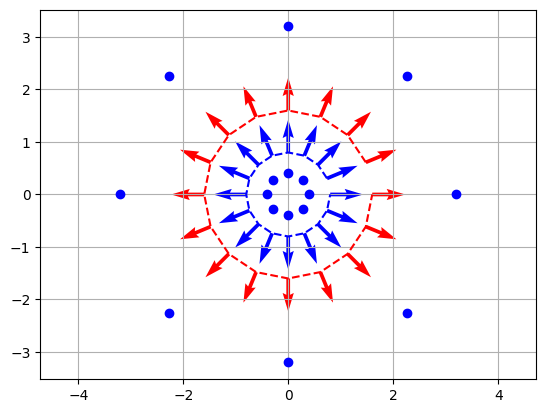

In [ ]:
plot_2d(Gamma1, Gamma2, source_points)

In [ ]:
from gpbr.direct.heat_equation.fundamental_sequence import fundamental_sequence_2d, FundamentalSequence

fundamental_sequence_gamma1 = fundamental_sequence_2d(Gamma1, source_points, mfs_data)
fundamental_sequence_gamma2 = fundamental_sequence_2d(Gamma2, source_points, mfs_data)

In [ ]:
from gpbr.direct.heat_equation.helpers import form_fs_matrix, form_fs_vector_2d
PHI_MAT = form_fs_matrix(fundamental_sequence_gamma1, fundamental_sequence_gamma2)
PHI_MAT.shape

(32, 16)

In [ ]:
PHI_MAT

array([[3.23010230e-06, 2.73551713e-07, 1.52446781e-08, 2.58827313e-09,
        2.58827313e-09, 1.52446781e-08, 2.73551713e-07, 3.23010230e-06,
        9.56681371e-02, 1.97206881e-02, 4.62463023e-03, 2.06453154e-03,
        2.06453154e-03, 4.62463023e-03, 1.97206881e-02, 9.56681371e-02],
       [4.77387264e-06, 1.13397585e-06, 6.03684693e-08, 5.15584128e-09,
        2.04417089e-09, 5.15584128e-09, 6.03684693e-08, 1.13397585e-06,
        1.32712453e-01, 4.56599531e-02, 8.97493161e-03, 2.81006458e-03,
        1.86004541e-03, 2.81006458e-03, 8.97493161e-03, 4.56599531e-02],
       [3.23010230e-06, 3.23010230e-06, 2.73551713e-07, 1.52446781e-08,
        2.58827313e-09, 2.58827313e-09, 1.52446781e-08, 2.73551713e-07,
        9.56681371e-02, 9.56681371e-02, 1.97206881e-02, 4.62463023e-03,
        2.06453154e-03, 2.06453154e-03, 4.62463023e-03, 1.97206881e-02],
       [1.13397585e-06, 4.77387264e-06, 1.13397585e-06, 6.03684693e-08,
        5.15584128e-09, 2.04417089e-09, 5.15584128e-09, 6.036

In [ ]:
from gpbr.direct.heat_equation.fundamental_sequence import FundamentalSequenceCoefs

alpha_coeeff = np.empty((N+1, M), dtype=np.float64)
alpha_coeeff[:] = np.nan
fs_coefs = FundamentalSequenceCoefs(alpha_coeeff)
from numpy.linalg import lstsq
for n in range(0, N+1):
    F = form_fs_vector_2d(n,
                          fundamental_sequence_gamma1,
                          fundamental_sequence_gamma2,
                          Gamma1,
                          Gamma2,
                          fs_coefs,
                          f1, f2, mfs_data)
    alpha_n = lstsq(PHI_MAT, F)[0]
    fs_coefs.alpha[n] = alpha_n.T
    print(fs_coefs.alpha)

[[-3.44641541e-05  4.11424213e-04 -3.44641541e-05  3.96950906e-06
  -4.74538782e-07  1.10469035e-07 -4.74538782e-07  3.96950906e-06
   3.17577496e-09 -1.72032226e-08  3.17577496e-09  1.06793030e-10
  -6.24306943e-11  1.72986657e-10 -6.24306944e-11  1.06793030e-10]
 [            nan             nan             nan             nan
              nan             nan             nan             nan
              nan             nan             nan             nan
              nan             nan             nan             nan]
 [            nan             nan             nan             nan
              nan             nan             nan             nan
              nan             nan             nan             nan
              nan             nan             nan             nan]
 [            nan             nan             nan             nan
              nan             nan             nan             nan
              nan             nan             nan             nan
       

In [ ]:
from gpbr.direct.common.boundary import Point2D
test_points = [Point2D(0.0, 0.98), Point2D(1.0, -0.73), Point2D(0.51, 0.54), Point2D(-0.501, 0.52), Point2D(-1.11, -0.75), Point2D(0.0, -1.0)]

In [ ]:
from gpbr.direct.heat_equation.helpers import u_2d
for n in range(0, N+1):
    print(f'N={n}')
    for p in test_points:
        u_approx = u_2d(p, n, source_points, fs_coefs, mfs_data)
        u_exact = u2de(p, mfs_data.tn[n])
        print(f'Difference: {abs(u_approx - u_exact)}')
        # print(f'u_approx={u_approx}, u_exact={u_exact}')

N=0
Difference: 3.9066794856549646e-09
Difference: 8.51513042226721e-12
Difference: 1.4972768660576572e-10
Difference: 1.784626575871667e-10
Difference: 1.6793872784732295e-11
Difference: 1.2189477131944364e-12
N=1
Difference: 4.637200256570756e-06
Difference: 4.082887220502182e-09
Difference: 2.7556587717559586e-07
Difference: 3.606114036715847e-07
Difference: 8.013144333423416e-09
Difference: 1.0340333348292328e-09
N=2
Difference: 1.6954070569315163e-05
Difference: 8.941498587993755e-10
Difference: 2.359846584382767e-06
Difference: 3.3125333428670937e-06
Difference: 5.1627702874703165e-09
Difference: 8.369990591347335e-09
N=3
Difference: 3.1544692111930696e-06
Difference: 1.4359394240284083e-07
Difference: 2.7907566271862574e-06
Difference: 3.983583734547264e-06
Difference: 3.1924337417955055e-07
Difference: 1.706349759139021e-08
N=4
Difference: 1.4350362108491192e-05
Difference: 7.250690113106045e-07
Difference: 1.7767428816745155e-07
Difference: 3.5547598110902525e-07
Difference: 1

In [ ]:
def du2de_vec(xp, t):
    # -0.125*x1*exp((-x1**2/4 - (x2 - 4)**2/4)/t)/(pi*t**2)
    # 0.25*(2 - x2/2)*exp((-x1**2/4 - (x2 - 4)**2/4)/t)/(pi*t**2)
    return Point2D(
        -0.125*xp.x*np.exp((-xp.x**2/4 - (xp.y - 4)**2/4)/t)/(np.pi*t**2),
        0.25*(2 - xp.y/2)*np.exp((-xp.x**2/4 - (xp.y  - 4)**2/4)/t)/(np.pi*t**2)
    )
    

In [ ]:
from gpbr.direct.heat_equation.helpers import dbu_2d
for n in range(0, N+1):
    print(f'N={n}')
    norms = []
    for x, nx in zip(Gamma1.points, Gamma1.normals):
        du_approx = dbu_2d(x, nx, n, source_points, fs_coefs, mfs_data)
        du_e_vec = du2de_vec(x, mfs_data.tn[n])
        du_exact = du_e_vec.x*nx.x + du_e_vec.y*nx.y
        norms.append(abs(du_approx - du_exact))
    print(f'Max difference: {max(norms)}')
    # print(f'Max difference: {np.linalg.norm(norms)}')

N=0
Max difference: 2.1293264769387242e-08
N=1
Max difference: 2.7373373781358973e-05
N=2
Max difference: 0.00012213307444786914
N=3
Max difference: 4.7619616816044685e-05
N=4
Max difference: 0.00013522181580476146
N=5
Max difference: 0.0001845660403924994
N=6
Max difference: 0.00018640978710150226
N=7
Max difference: 0.00017117954795992704
N=8
Max difference: 0.0001488915819131357
N=9
Max difference: 0.00013303996453409468
N=10
Max difference: 0.00011486626441451452
